# RNN

## Препроцессинг датасета

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [8]:
df = pd.read_csv('resources/Steel_industry_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

Разбиваем столбец date

In [9]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df = df.drop('date', axis=1) # год везде одинаковый

Преобразовываем в категариальный признак

In [10]:
le = LabelEncoder()
df['WeekStatus'] = le.fit_transform(df['WeekStatus'])
df['Day_of_week'] = le.fit_transform(df['Day_of_week'])
df['Load_Type'] = le.fit_transform(df['Load_Type'])

Строим матрицу корреляции 

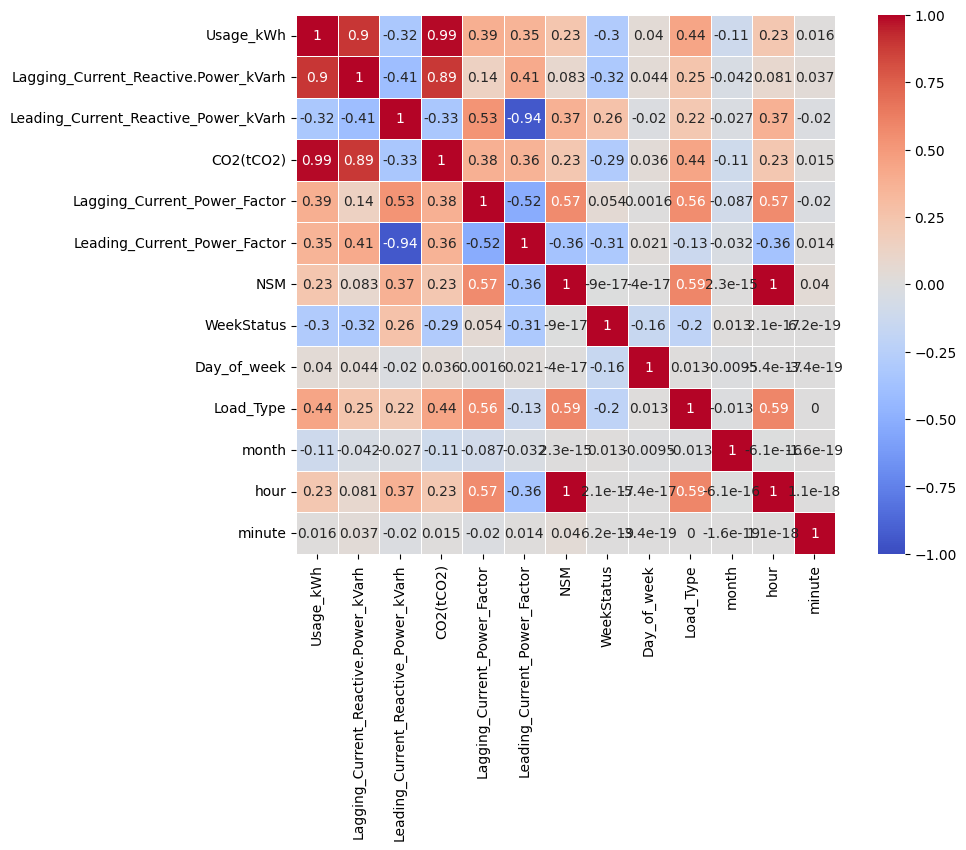

In [14]:
plt.figure(figsize=(11, 7))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True)
plt.show()

Посчитаем gain ratio для каждого зависимого признака

In [15]:
def split_data_into_intervals(data: pd.DataFrame):
    data = data.copy()
    for i in data.columns:
        n_intervals = int(np.ceil(np.log2(data[i].count()) + 1))
        data[i] = pd.cut(data[i], n_intervals)
    return data


def calc_entropy(data: pd.DataFrame, attribute):
    entropy = 0
    capacity = data[attribute].count()
    for i in data[attribute].value_counts():
        p = i / capacity
        if p == 0:
            continue
        entropy += -p * np.log2(p)
    return entropy


def calc_conditional_entropies(data: pd.DataFrame, attribute, target):
    data_values = data[attribute].value_counts().sort_index()
    entropies = []
    for i in range(len(data_values)):
        target_data = data[data[attribute] == data_values.index[i]]
        if target_data[target].count() == 0:
            entropies.append([data_values.iloc[i], 0])
        else:
            entropies.append([data_values.iloc[i], calc_entropy(target_data, target)])
    return entropies


def calc_information_gain(data: pd.DataFrame, attribute, target):
    entropy = calc_entropy(data, target)
    conditional_entropies = calc_conditional_entropies(data, attribute, target)
    for i in range(len(conditional_entropies)):
        entropy -= conditional_entropies[i][0] * conditional_entropies[i][1] / data[attribute].count()
    return entropy


def calc_split_info(data: pd.DataFrame, attribute):
    split_info = 0
    for i in range(len(data[attribute].value_counts())):
        d = data[attribute].value_counts().iloc[i] / data[attribute].count()
        if d == 0:
            continue
        split_info += -d * np.log2(d)
    return split_info


def calc_gain_ratio(data: pd.DataFrame, attribute, target):
    information_gain = calc_information_gain(data, attribute, target)
    split_info = calc_split_info(data, attribute)
    if split_info == 0:
        return 0
    return information_gain / split_info

In [23]:
df_upd = split_data_into_intervals(df)
attributes = df_upd.columns.drop('Usage_kWh')
gain_ratios_dir = {}
for attribute in attributes:
    gain_ratios_dir[attribute] = calc_gain_ratio(df_upd, attribute, 'Usage_kWh')

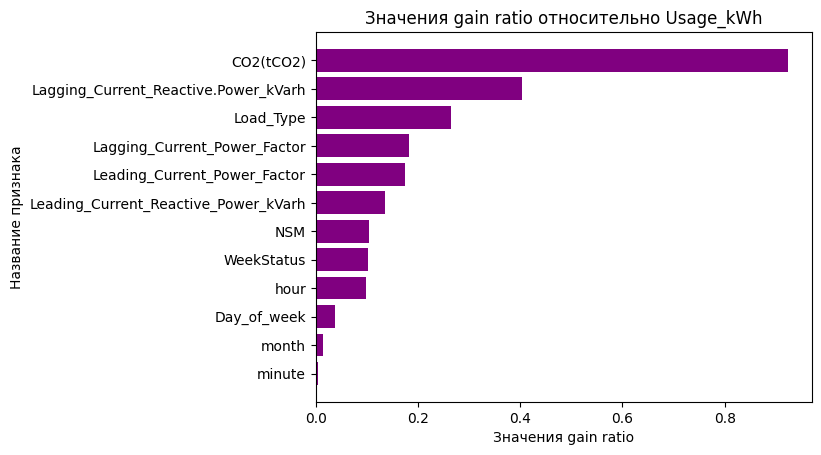

In [25]:
attributes = list(gain_ratios_dir.keys())
gain_ratios = list(gain_ratios_dir.values())

sorted_kgf_indices = sorted(range(len(gain_ratios)), key=gain_ratios.__getitem__)
titles = [attributes[i] for i in sorted_kgf_indices]
values = [gain_ratios[i] for i in sorted_kgf_indices]

plt.barh(titles, values, color='purple')
plt.title("Значения gain ratio относительно Usage_kWh")
plt.xlabel("Значения gain ratio")
plt.ylabel("Название признака")
plt.show()

Удаляем признаки с высокой корреляцией или с низким gain ratio

In [26]:
df = df.drop(['minute', 'month', 'Day_of_week', 'hour', 'WeekStatus', 'NSM', ], axis=1)
df.head(3)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Load_Type
0,3.17,2.95,0.0,0.0,73.21,100.0,0
1,4.00,4.46,0.0,0.0,66.77,100.0,0
2,3.24,3.28,0.0,0.0,70.28,100.0,0


In [28]:
df.to_csv('resources/Clear_steel_industry_data.csv')